[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PLN-disca-iimas/DigitalHumanitiesSchool/blob/main/demo_transformers_for_medical_entity_detection.ipynb)

# Transformers for medical entity detection

Orlando Ramos-Flores, Rodrigo del Moral

Summer School on Digital Humanities

IIMAS, UNAM. Mexico. 2023

**Before running the notebook, please make sure you are using a GPU runtime type.**

We are going to use the Hugging Face set of libraries:

<img src="https://camo.githubusercontent.com/3768a036d6ad1cd8f4a9c73f1dfc4c887d2639fbf63c65b7664311529a92ec9f/68747470733a2f2f6769746875622e636f6d2f7269636b69657061726b2f6e6c702d776974682d7472616e73666f726d6572732f626c6f622f6d61696e2f696d616765732f6368617074657230315f68662d65636f73797374656d2e706e673f7261773d31"/>

Image source: https://www.kaggle.com/code/cocoyachi/look-around-huggingface




Install libraries required and import them

In [1]:
## Install and import required libraries

! pip install transformers datasets evaluate seqeval nltk -q
! pip install -U accelerate -q
! pip install wordcloud -q

import os
# import datasets
# import transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.9 MB/s eta 0:00:00


## Load and explore the pre-trained model

We use a RoBERTa-based model trained on a biomedical-clinical corpus in Spanish.

The training corpus is composed of several biomedical corpora in Spanish, collected from publicly available corpora and crawlers, and a real-world clinical corpus collected from more than 278K clinical documents and notes.



First, we need to import the same tokenizer employed in the model training.

The training corpus has been tokenized using a byte version of Byte-Pair Encoding (BPE) used in the original RoBERTA model with a vocabulary size of 52,000 tokens.

In the next step, we need to import the Masked Language Model (MLM) following the approach employed for the RoBERTa base model with the same hyperparameters.

In [2]:
## Loading model and associated tokenizer

from transformers import AutoTokenizer, AutoModelForMaskedLM

pretrained_model_name = "BSC-TeMU/roberta-base-biomedical-es"

# import tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
# import MLM
mlm_model = AutoModelForMaskedLM.from_pretrained(pretrained_model_name)

### Model demonstration

The model is ready to be used only for masked language modeling to perform the Fill Mask task.

In [3]:
# Demo
from transformers import pipeline

unmasker = pipeline('fill-mask', model=mlm_model, tokenizer=tokenizer)
# The vascular system is the network of <mask> in the body.
unmasker("El sistema vascular es la red de <mask> del cuerpo.")

[{'score': 0.4036727249622345,
  'token': 5459,
  'token_str': ' vasos',
  'sequence': ' El sistema vascular es la red de vasos del cuerpo.'},
 {'score': 0.11213746666908264,
  'token': 16331,
  'token_str': ' capilares',
  'sequence': ' El sistema vascular es la red de capilares del cuerpo.'},
 {'score': 0.10953008383512497,
  'token': 1772,
  'token_str': ' sangre',
  'sequence': ' El sistema vascular es la red de sangre del cuerpo.'},
 {'score': 0.10756144672632217,
  'token': 7325,
  'token_str': ' arterias',
  'sequence': ' El sistema vascular es la red de arterias del cuerpo.'},
 {'score': 0.10554944723844528,
  'token': 10216,
  'token_str': ' venas',
  'sequence': ' El sistema vascular es la red de venas del cuerpo.'}]

## Load, explore and prepare the dataset

### DisTEMIST corpus

The DISTEMIST corpus is a collection of 1,000 clinical cases in Spanish from different medical specialties such as:

* cardiology
* oncology
* otorhinolaryngology
* dentistry
* pediatrics
* primary care
* allergology
* radiology
* psychiatry
* ophthalmology
* urology

Annotated with disease mentions. Each of the mentions in the corpus has been standardized using SNOMED-CT terminology.

The DisTEMIST corpus has been randomly divided into:

* **Training set**: 750 clinical cases
* **Test set**: 250 additional cases

### Download and explore the dataset

We need to load the DisTEMIST corpus from [Zenodo](https://zenodo.org/record/7614764).

In [4]:
## Download the raw dataset
DL_DIR = '/content'
! pip install -q zenodo_get
! zenodo_get -r 7614764 -o {DL_DIR}

## Unzip the dataset
! unzip -q {DL_DIR}/distemist_zenodo.zip -d {DL_DIR}

  Preparing metadata (setup.py) ... done
Title: DisTEMIST corpus: detection and normalization of disease mentions in spanish clinical cases
Keywords: NLP, gold standard, corpus, normalization, NER, Entity Grounding, Entity Linking, Diseases, bionlp
Publication date: 2022-05-09
DOI: 10.5281/zenodo.7614764
Total size: 15.0 MB

Link: https://zenodo.org/api/files/74077546-1b2f-4a18-a82b-6ad3bd528758/distemist_zenodo.zip   size: 15.0 MB

Checksum is correct. (bc84461ad07b59a94c79ca9c648952c2)
All files have been downloaded.


The DisTEMIST dataset is annotated in with the BRAT format, as shown in the image below.

<img src="https://temu.bsc.es/distemist/wp-content/uploads/2022/05/Screenshot-from-2022-05-02-17-24-42.png">

![image annotation](https://temu.bsc.es/distemist/wp-content/uploads/2022/04/Screenshot-from-2022-04-13-15-26-59-1024x218.png)

In [5]:
## Take a look at the annotations format
DATA_DIR = DL_DIR + '/distemist_zenodo'
! head -n 5 {DATA_DIR}/training/subtrack1_entities/distemist_subtrack1_training_mentions.tsv

filename	mark	label	off0	off1	span
es-S0210-56912007000900007-3	T1	ENFERMEDAD	164	166	DM
es-S0210-56912007000900007-3	T2	ENFERMEDAD	362	376	deshidratación
es-S0210-56912007000900007-3	T3	ENFERMEDAD	575	590	hiperamilasemia
es-S0210-56912007000900007-3	T4	ENFERMEDAD	715	733	pancreatitis aguda


In [6]:
## Open a clinical note
! head -n 5 {DATA_DIR}/training/text_files/es-S0210-56912007000900007-3.txt

Mujer de 74 años que ingresó en el hospital por obnubilación y anuria tras presentar durante 5 días dolor abdominal y vómitos. Entre sus antecedentes destacaba una DM tratada con metformina (850 mg/8 h) y glibenclamida. La presión arterial era de 105/60 mmHg, la frecuencia cardíaca de 155 latidos/minuto y la temperatura de 36,7º C. En la exploración destacaba deshidratación intensa, desorientación, respiración de Kussmaul, dolor abdominal con peristaltismo débil y ausencia de defensa abdominal. La tabla 2 muestra los principales datos analíticos, destacando además una hiperamilasemia de 2.605 U/l. Una tomografía computarizada abdominal descubrió un aumento del tamaño de la cabeza del páncreas sugerente de pancreatitis aguda. Tras suspender la administración de metformina, la paciente fue intubada orotraquealmente y conectada a un respirador mecánico. También recibió tratamiento a base de fluidos con suplementos de potasio, noradrenalina, bicarbonato, insulina, amiodarona, imipenen y fu

### Load dataset and transform it to a HF Dataset object

* We need to prepare/transform/set up the DisTEMIST dataset:

 1. Extract labels from BRAT format
 2. Load the raw texts
 3. Perform a simple tokenization and align the text with its labels
 4. Split the texts into sentences


* How do we aligh the split texts with its labels?

 We use the IOB tagging scheme for **I**nside, **O**utside and **B**eginning tokens.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*Q6ZVf0taZuB_Ca2IfMdWrw.png"/>



In [7]:
## Read and import the dataset

## Import a custom sentence tokenizer
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")
punkt_tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')

## Split texts into sentences
def sent_split(text):
    return punkt_tokenizer.tokenize(text)

## Read the entire .tsv with annotations and convert it to a dictionary
## where each key is a filename and each value a tuple with the annotations
## in (start, end, label, span) format
def load_annotations_from_tsv(tsv_file):
    annotations = {}
    with open(tsv_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            filename, _, label, start, end, span = line.strip().split('\t')
            filename = filename + '.txt'
            if filename not in annotations:
                annotations[filename] = []
            annotations[filename].append((int(start), int(end), label, span))
    return annotations

## Recieve a text and a list of tags in (start, end, label, span) format
## and return a sorted list of annotated sentences in (span, label) format
def brat_to_line_by_line(text, annotations_for_file):
    sentences = sent_split(text)

    all_tokens_labels = []
    offset = 0

    for sentence in sentences:
        tokens_labels = []
        sentence_end = offset + len(sentence)

        entities = [e for e in annotations_for_file if e[0] >= offset and e[1] <= sentence_end]
        entities = sorted(entities, key=lambda x: x[0])

        prev_end = offset
        for start, end, label, word in entities:
            tokens_labels.extend([(token, 'O') for token in sentence[prev_end - offset:start - offset].split()])

            # Split the entity word and add the IOB tags
            entity_tokens = word.split()
            tokens_labels.append((entity_tokens[0], 'B-' + label))  # Begin tag for first token
            tokens_labels.extend([(token, 'I-' + label) for token in entity_tokens[1:]])  # Inside tags for subsequent tokens

            prev_end = end - offset

        tokens_labels.extend([(token, 'O') for token in sentence[prev_end - offset:].split()])
        all_tokens_labels.append(tokens_labels)
        offset += len(sentence) + 1  # +1 for the space or punctuation after the sentence

    return all_tokens_labels

def transform_data(annotations_dir, texts_path):
    transformed_data = []
    annotations = load_annotations_from_tsv(annotations_dir)
    for filename in os.listdir(texts_path):
        if filename.endswith('.txt'):
            with open(os.path.join(texts_path, filename), 'r') as f:
                text = f.read()

            file_annotations = annotations.get(filename, [])
            tokens_labels = brat_to_line_by_line(text, file_annotations)
            transformed_data.append(tokens_labels)
    return transformed_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
## Read and import train and test datasets
train_ann_path = os.path.join(DATA_DIR,'training','subtrack1_entities','distemist_subtrack1_training_mentions.tsv')
train_texts_path = os.path.join(DATA_DIR, 'training', 'text_files')

train_data = transform_data(train_ann_path, train_texts_path)

test_ann_path = os.path.join(DATA_DIR,'test_annotated','subtrack1_entities','distemist_subtrack1_test_mentions.tsv')
test_texts_path = os.path.join(DATA_DIR, 'test_annotated', 'text_files')

test_data = transform_data(test_ann_path, test_texts_path)

In [9]:
print(f"We have loaded {len(train_data)} training documents with labels.")
print(f"We have loaded {len(test_data)} test documents with labels.")

We have loaded 750 training documents with labels.
We have loaded 250 test documents with labels.


* Explore one sentence of one document

In [10]:
print(f"Length of example document: {len(train_data[0])} sentences")

print(f"Length of example sentence: {len(train_data[0][0])} tokens")
print(*train_data[0][0], sep="\n")

Length of example document: 17 sentences
Length of example sentence: 26 tokens
('Varón', 'O')
('de', 'O')
('38', 'O')
('años', 'O')
('que', 'O')
('acude', 'O')
('remitido', 'O')
('por', 'O')
('su', 'O')
('médico', 'O')
('por', 'O')
('urgencias', 'O')
('para', 'O')
('valoración', 'O')
('de', 'O')
('lesión', 'B-ENFERMEDAD')
('en', 'I-ENFERMEDAD')
('labio', 'I-ENFERMEDAD')
('inferior', 'I-ENFERMEDAD')
('de', 'O')
('un', 'O')
('mes', 'O')
('y', 'O')
('medio', 'O')
('de', 'O')
('evolución.', 'O')


We use [datasets](https://huggingface.co/docs/datasets/index), it is a library for easily accessing and sharing datasets for Audio, Computer Vision, and Natural Language Processing (NLP) tasks.

You can think of a `dataset` object as an analogue of a `pandas` DataFrame, since both libraries implement their own data structures.

The `datasets` library is part of the HuggingFace libraries set, and for this reason it is recommended to use it in conjunction with the `transformers` library, since they are designed to work together.

In [11]:
## Create a Datasets object

from datasets import Dataset, DatasetDict

def tokens_labels_to_dataset(train_data, test_data):
    train_tokens_list = []
    train_labels_list = []
    test_tokens_list = []
    test_labels_list = []

    for document in train_data:
        for sentence in document:
            tokens = [item[0] for item in sentence]
            tags = [item[1] for item in sentence]

            train_tokens_list.append(tokens)
            train_labels_list.append(tags)

    for document in test_data:
        for sentence in document:
            tokens = [item[0] for item in sentence]
            tags = [item[1] for item in sentence]

            test_tokens_list.append(tokens)
            test_labels_list.append(tags)

    return DatasetDict({
    'train': Dataset.from_dict({'tokens': train_tokens_list, 'ner_labels': train_labels_list}),
    'test': Dataset.from_dict({'tokens': test_tokens_list, 'ner_labels': test_labels_list})
    })

dataset = tokens_labels_to_dataset(train_data, test_data)

In [12]:
## Dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_labels'],
        num_rows: 11891
    })
    test: Dataset({
        features: ['tokens', 'ner_labels'],
        num_rows: 3952
    })
})

In [13]:
## Extract half of the test tags and turn them into a validation set

split_percentage = 0.5  # 50% for validation
split = dataset["test"].train_test_split(test_size=split_percentage, shuffle=False)

# Update the Dataste
dataset["validation"] = split["train"]
dataset["test"] = split["test"]

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_labels'],
        num_rows: 11891
    })
    test: Dataset({
        features: ['tokens', 'ner_labels'],
        num_rows: 1976
    })
    validation: Dataset({
        features: ['tokens', 'ner_labels'],
        num_rows: 1976
    })
})

### Transform string labels to numeric labels

In [15]:
## Print an example of the labels before converting into IDs
print(dataset['train'][0]['ner_labels'])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ENFERMEDAD', 'I-ENFERMEDAD', 'I-ENFERMEDAD', 'I-ENFERMEDAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [16]:
## Convert str labels to ids (int labels)
unique_labels = set()
for subset in ["train", "test", "validation"]:
    labels_in_subset = set([label for labels in dataset[subset]["ner_labels"] for label in labels])
    unique_labels.update(labels_in_subset)

# Ensure "O" is removed from the unique_labels set because we will assign it manually
unique_labels.discard("O")

# Ensure 'O' gets id 0, 'B' tags even ids and 'I' tags odd ids.
label2id = {"O": 0}
current_id = 1  # Start with 1 because 0 is assigned to 'O'

for label in sorted(unique_labels):
    if label == 'O':  # Skip 'O' as it's already assigned
        continue
    if label.startswith('B-'):
        label2id[label] = current_id
        corresponding_i_tag = 'I-' + label[2:]
        if corresponding_i_tag in unique_labels:
            label2id[corresponding_i_tag] = current_id + 1
        current_id += 2

id2label = {id: label for label, id in label2id.items()}

def convert_labels_to_ids(example):
    return {"ner_labels": [label2id[label] for label in example["ner_labels"]]}

dataset = dataset.map(convert_labels_to_ids)

Map:   0%|          | 0/11891 [00:00<?, ? examples/s]

Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

In [17]:
## Print the same example of labels after converting to IDs

print(dataset['train'][0]['ner_labels'])
print(f"Dictionary for conversion: {id2label}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Dictionary for conversion: {0: 'O', 1: 'B-ENFERMEDAD', 2: 'I-ENFERMEDAD'}


### Training corpus exploration


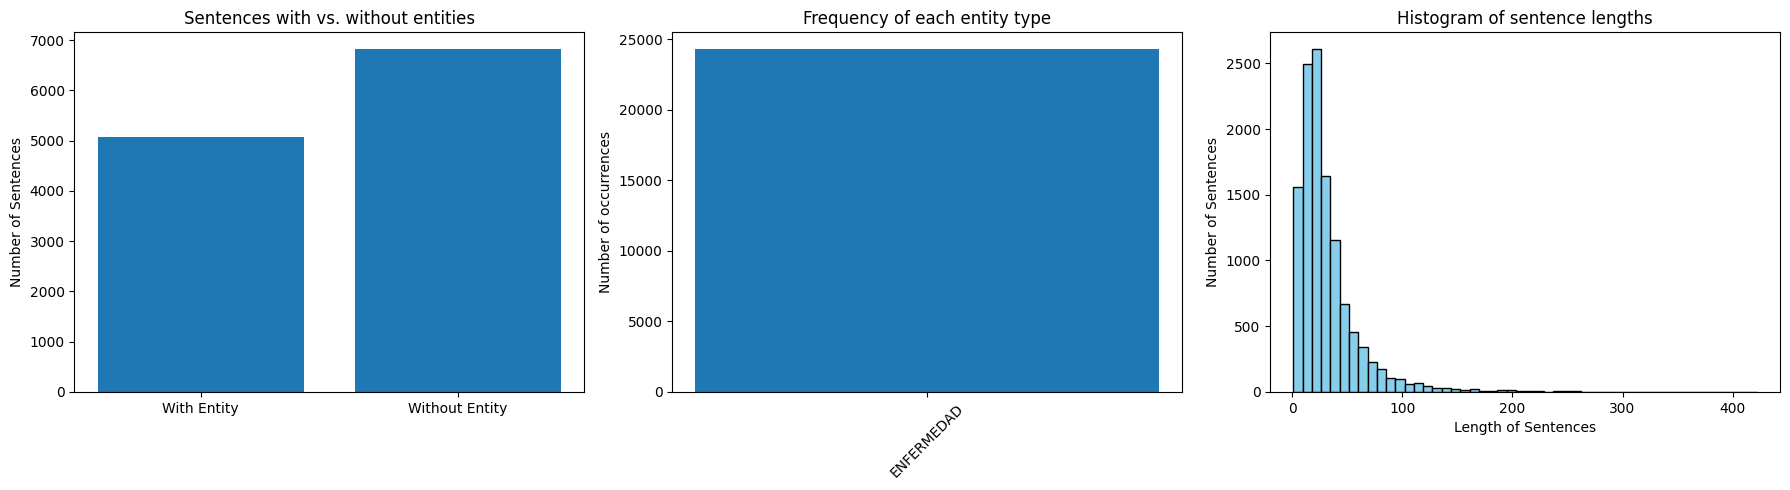

In [18]:
import matplotlib.pyplot as plt

# 1. Count sentences with and without entities
with_entity = sum(1 for item in dataset['train'] if any(id2label[tag] != 'O' for tag in item['ner_labels']))
without_entity = len(dataset['train']) - with_entity

# 2. Count frequency of each entity type (excluding 'O')
from collections import Counter
all_tags = [id2label[tag][2:] if id2label[tag].startswith(('B-', 'I-')) else id2label[tag] for item in dataset['train'] for tag in item['ner_labels'] if id2label[tag] != 'O']
tag_counts = Counter(all_tags)

# 3. Calculate sentence lengths
sentence_lengths = [len(tokens) for tokens in dataset['train']['tokens']]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for sentences with vs. without entities
axs[0].bar(['With Entity', 'Without Entity'], [with_entity, without_entity])
axs[0].set_title('Sentences with vs. without entities')
axs[0].set_ylabel('Number of Sentences')

# Plot for frequency of each entity type
axs[1].bar(tag_counts.keys(), tag_counts.values())
axs[1].set_title('Frequency of each entity type')
axs[1].set_ylabel('Number of occurrences')
axs[1].tick_params(axis='x', rotation=45)  # Rotating x-axis labels for better visibility

# Histogram for sentence lengths
axs[2].hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
axs[2].set_title('Histogram of sentence lengths')
axs[2].set_xlabel('Length of Sentences')
axs[2].set_ylabel('Number of Sentences')

plt.tight_layout()
plt.show()


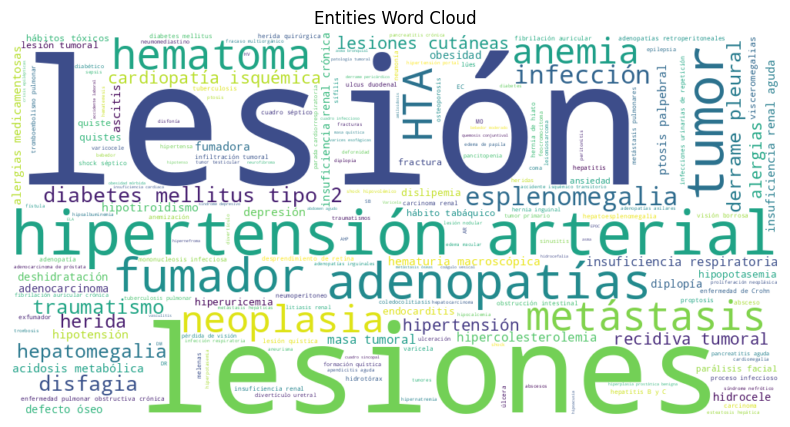

In [19]:
## Draw a WordCloud from the entities

from collections import Counter
from wordcloud import WordCloud

merged_entities = []

for item in dataset['train']:
    entity_phrase = ""
    for token, tag_id in zip(item['tokens'], item['ner_labels']):
        tag = id2label[tag_id]
        if tag.startswith('B-'):
            if entity_phrase:  # Save the previous entity phrase if there is any
                merged_entities.append(entity_phrase)
            entity_phrase = token  # Start a new entity phrase
        elif tag.startswith('I-'):
            entity_phrase += " " + token  # Add the token to the current entity phrase
        else:
            if entity_phrase:  # Save the previous entity phrase if there is any
                merged_entities.append(entity_phrase)
            entity_phrase = ""  # Reset entity phrase

    if entity_phrase:  # Add the last entity phrase if there is any
        merged_entities.append(entity_phrase)

# Get the frequencies of each merged entity
entity_counts = Counter(merged_entities)

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(entity_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Entities Word Cloud')
plt.show()


### Tokenize with the RoBERTa tokenizer

We tokenize the the train and test data

In [20]:
## Declare the pre-trained tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [38]:
## Test the BERT/RoBERTa tokenizer

inputs = tokenizer(dataset['train'][0]["tokens"], is_split_into_words=True)

print(*inputs.tokens(), sep="\n")
# print(*[tokenizer.decode([x]) for x in inputs['input_ids']], sep="\n")

<s>
ĠVarÃ³n
Ġde
Ġ38
ĠaÃ±os
Ġque
Ġacude
Ġremitido
Ġpor
Ġsu
ĠmÃ©dico
Ġpor
Ġurgencias
Ġpara
ĠvaloraciÃ³n
Ġde
ĠlesiÃ³n
Ġen
Ġlabio
Ġinferior
Ġde
Ġun
Ġmes
Ġy
Ġmedio
Ġde
ĠevoluciÃ³n
.
</s>


In [39]:
## Align labels with tokens for subword splitting

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

## Tokenize with BERT/RoBERTa tokenizer
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_labels"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

## Do BERT tokenization (map dataset)
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/11891 [00:00<?, ? examples/s]

Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

In [41]:
# Print one tokenized sentence
[print(i, tokenized_dataset['train'][0][i], sep="\t") for i in tokenized_dataset['train'][0]]

input_ids	[0, 22958, 262, 6237, 638, 298, 11508, 25492, 346, 335, 1216, 346, 4795, 358, 3719, 262, 3198, 288, 16685, 3305, 262, 304, 1003, 290, 1558, 262, 2555, 17, 2]
attention_mask	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels	[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, -100]


[None, None, None]

### Data Collator

In [ ]:
## Show a batch passed through the DataCollator
batch = [tokenized_dataset["train"][i] for i in range(2)]
print(batch[0]["labels"])
print(batch[1]["labels"])

[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, -100]
[-100, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [ ]:
## Declare DataCollator (this performs the padding and truncating)
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
## Show a batch passed through the DataCollator
batch = data_collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    1,    2,    2,    2,    0,    0,    0,    0,
            0,    0,    0,    0, -100],
        [-100,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0, -100, -100, -100]])

## Classification algorithm

### Evaluation metrics

In [ ]:
## Load evaluation library
import evaluate
metric = evaluate.load("seqeval")

## Print an evaluation example (where pred = real)
labels = dataset["train"][0]["ner_labels"]
labels = [id2label[i] for i in labels]
predictions = labels.copy()
metric.compute(predictions=[predictions], references=[labels])

{'ENFERMEDAD': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
## Evaluate (convert back to string, )

import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

### NER Fine-tunning (Training)

Simple fine-tunning network based on [huggingface documentation](https://huggingface.co/learn/nlp-course/chapter7/2#fine-tuning-the-model-with-the-trainer-api)

In [ ]:
## Define from_pretrained NER model

from transformers import AutoModelForTokenClassification

ner_model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id,
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-biomedical-es and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## Just to check

ner_model.config.num_labels

3

In [ ]:
## Define output path:

output_dir = "biomed-finetuned-ner"

In [ ]:
## Define training parameters

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir, # output_dir
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    do_train=True,
    do_eval=True,
    push_to_hub=False,
)

In [ ]:
## Define training cycle

from transformers import Trainer

trainer = Trainer(
    model=ner_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

* Let's think about what we have done so far

In [ ]:
## Training execution

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.025200,0.026304,0.847059,0.895801,0.870748,0.991890
2,0.013400,0.025776,0.890673,0.905910,0.898227,0.992379
3,0.005700,0.028214,0.890411,0.909798,0.900000,0.992467


TrainOutput(global_step=2232, training_loss=0.02840740932652386, metrics={'train_runtime': 941.7473, 'train_samples_per_second': 37.88, 'train_steps_per_second': 2.37, 'total_flos': 2414093057467182.0, 'train_loss': 0.02840740932652386, 'epoch': 3.0})

In [ ]:
ner_model.save_pretrained(output_dir)

## Prediction demo

In [ ]:
## Prediction

from transformers import pipeline

model_checkpoint = output_dir
token_classifier = pipeline(
    "token-classification",
    model=model_checkpoint,
    tokenizer=pretrained_model_name,
    aggregation_strategy="simple"
)

* Let's try the sentence: "Como antecedentes personales presenta insuficiencia renal crónica y displasia quística renal bilateral, diagnosticadas en el primer mes de vida, e hiperglucemias de reciente detección en tratamiento con insulina."

In [ ]:
## Interactive prediction

token_classifier("Como antecedentes personales presenta insuficiencia renal crónica y displasia quística renal bilateral, diagnosticadas en el primer mes de vida, e hiperglucemias de reciente detección en tratamiento con insulina.")


[{'entity_group': 'ENFERMEDAD',
  'score': 0.9980822,
  'word': ' insuficiencia renal crónica',
  'start': 38,
  'end': 65},
 {'entity_group': 'ENFERMEDAD',
  'score': 0.8649561,
  'word': ' displasia quística renal',
  'start': 68,
  'end': 92},
 {'entity_group': 'ENFERMEDAD',
  'score': 0.98624516,
  'word': ' hiperglucemias',
  'start': 147,
  'end': 161}]